In [74]:
# pour les imports
import numpy as np
import scipy.special as sp
import matplotlib.pyplot as plt
import scipy.stats as ss
from tqdm import trange
from copy import deepcopy

In [75]:
n=7
m=11
points_1_10=[1,2, 3, 4, 5, 6, 7, 8, 9, 10] 
Narms=len(points_1_10)
maxPointsEnemmy=10000 # the maximum number of points of each palyer
maxPointsAgent=10000

# Zayed

In [76]:
class Cards:
    def __init__(self):
        self.ncards = (m-n+1)*4  # number of cards
        self.cards = 4*[i for i in range(n,m+1)]  # cards 

    def shuffle(self):
        '''Knuth shuffle'''
        np.random.shuffle(self.cards)

    def hands(self):
        '''distribution of cards by the agent :)'''
        self.hand1 = [self.cards[0], self.cards[2]]
        self.hand2 = [self.cards[1], self.cards[3]]



In [77]:
class Enemies :
    '''many enemies'''

    def __init__(self):
        self.maxPoints= maxPointsEnemmy # the maximum amount of points that the enemy has
        self.points= points_1_10
        
    def enemy1(self, hand1): # the enemy hand
        goforpoints = None
        if hand1[0]+hand1[1] >= 18:  # (the mean of all possible hands)
            goforpoints = np.random.choice(self.points[5:])
        else:
            goforpoints = np.random.choice(self.points[:5])
        return goforpoints
    def deterministic(self, hand1):
        sum=hand1[0]+hand1[1]
        goforpoints=None
        ## you need to add 1 for the deterministic ???????????
        if(sum==14):
            goforpoints=2
        if(sum==15):
            goforpoints=3
        if(sum==16):
             goforpoints=4
        if(sum==17):
             goforpoints=5
        if(sum==18):
             goforpoints=6
        if(sum==19):
              goforpoints=7
        if(sum==20):
              goforpoints=8
        if(sum==21):
               goforpoints=9
        if(sum==22):
            goforpoints=10
        return goforpoints
    def Human(self, hand1):
        goforpoints = None

        while not (goforpoints in self.points):
            print("your hand ", hand1)
            goforpoints = int(input("Input your action (int): ")) 

        return goforpoints
    


In [78]:
def mapTo1422(sampled,a14,b22):
    # int is not important
    return (b22-a14)*sampled+a14 # the distribution of an arm (a point) ?? 

In [79]:
class ThompsonSampling :
    def __init__(self,alist,blist):
        self.maxPoints= maxPointsAgent  # the maximum amount of points that the agent has
        # self.points = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
        # we can keep track of this beta =>  the agent learn  ?????
        self.alist = alist
        self.blist = blist

    def chooseArmToGo(self,hand2,enemyResponse): # like an arm
        # sample the distrubution of the arm number enemyResponse
        if(enemyResponse==1):

            return True # always go it is a strategy
        else:
            estimated =np.random.beta(self.alist[enemyResponse-1],self.blist[enemyResponse-1])

            estimatedSumEnemyHand=mapTo1422(estimated,14,22) # according to the agent technique
            if(np.sum(hand2)>=estimatedSumEnemyHand): # if the agent hand is grater the the sampled enamy hand
                return True # go for
            else :
                return False # go for -1
    def updateBeta(self, gowith,enemyResponse,hand1,hand2):
        h2=np.sum(hand2) # agent
        h1=np.sum(hand1)
        if(enemyResponse !=1):
            if(gowith) and h2<h1 :
                self.alist[enemyResponse-1]+=enemyResponse # shift bata to the right (we need to adapte the learning parameter)
            if  h1<=h2 and not (gowith):    
                self.blist[enemyResponse-1]+=enemyResponse # shift bata to the left




    

In [80]:
class Exp3 :
    def __init__(self,lr):
        self.maxPoints = maxPointsAgent
        self.lr = lr
        self.armsIWE = np.ones((Narms,2*(m-n)+1)) # importance-weighted estimator
        self.ListSumHands=np.arange(2*n,2*m+1)
        self.estimatedSumEnemyHand = None
    
    def chooseArmToGo(self,hand2,enemyResponse): # like an arm
        # sample the distrubution of the arm number enemyResponse
        if(enemyResponse==1):

            return True # always go it is a strategy
        else:
              # according to the agent technique
            estimatedSumEnemyHand = np.random.choice(self.ListSumHands,p=self.armsIWE[enemyResponse-1, :]/(np.sum(self.armsIWE[enemyResponse-1, :])))
            self.estimatedSumEnemyHand = estimatedSumEnemyHand


            if(np.sum(hand2)>=estimatedSumEnemyHand): # if the agent hand is grater the the sampled enamy hand
                return True # go for
            else :
                return False # go for -1
    def updateIWE(self, gowith,enemyResponse,hand1,hand2):
        h2=np.sum(hand2) # agent
        h1=np.sum(hand1)
        if(enemyResponse !=1):
            if (gowith) and h2<h1 :
                self.armsIWE[enemyResponse-1,self.estimatedSumEnemyHand-14]*=np.exp(-self.lr*enemyResponse) 
            if  h1<=h2 and not (gowith):
                self.armsIWE[enemyResponse-1,self.estimatedSumEnemyHand-14]*=np.exp(-self.lr) 
            if (gowith) and h2>h1:
                self.armsIWE[enemyResponse-1,self.estimatedSumEnemyHand-14]*=1 # it seems to be good to model the reward in (-infiny,0]

        # reward == 0 if gowith and h2==h1


    

In [81]:
# test
enemy=Enemies()
b=[1 for i in range(10)]
a=[1 for i in range(10)]
agent=Exp3(0.2)
while(enemy.maxPoints>=10 and agent.maxPoints>=10):
    cards = Cards()
    cards.shuffle()
    cards.hands()
    hand1= cards.hand1
    hand2=cards.hand2
    EnemyGoFor=enemy.deterministic(hand1)
    AgentGo=agent.chooseArmToGo(hand2,EnemyGoFor)
    #show cards
    if(AgentGo):
        if(np.sum(hand1)>np.sum(hand2)):
            # agent loses
            agent.maxPoints-=EnemyGoFor
        if(np.sum(hand2)>np.sum(hand1)):
            # agent loses
            enemy.maxPoints-=EnemyGoFor
    else :
        agent.maxPoints-=1
    # update agent strategy
    agent.updateIWE(AgentGo,EnemyGoFor,hand1,hand2)
    print("=========Enemy========")
    print("hand1 ", hand1)
    print("GoFor", EnemyGoFor)
    print("maxPoints= ", enemy.maxPoints)
    print("=========Agent========")
    print("hand2 ", hand2)
    print("GoFor",AgentGo)
    print("maxPoints= ", agent.maxPoints)
if(enemy.maxPoints <10):
    print("Enemy losed")
if(agent.maxPoints <10):
    print("Agent losed")




=========Enemy========
hand1  [10, 9]
GoFor 7
maxPoints=  9993
=========Agent========
hand2  [11, 9]
GoFor True
maxPoints=  10000
=========Enemy========
hand1  [7, 11]
GoFor 6
maxPoints=  9993
=========Agent========
hand2  [11, 7]
GoFor True
maxPoints=  10000
=========Enemy========
hand1  [7, 9]
GoFor 4
maxPoints=  9993
=========Agent========
hand2  [11, 9]
GoFor False
maxPoints=  9999
=========Enemy========
hand1  [8, 9]
GoFor 5
maxPoints=  9988
=========Agent========
hand2  [10, 11]
GoFor True
maxPoints=  9999
=========Enemy========
hand1  [7, 10]
GoFor 5
maxPoints=  9988
=========Agent========
hand2  [8, 7]
GoFor True
maxPoints=  9994
=========Enemy========
hand1  [9, 7]
GoFor 4
maxPoints=  9988
=========Agent========
hand2  [8, 8]
GoFor False
maxPoints=  9993
=========Enemy========
hand1  [8, 7]
GoFor 3
maxPoints=  9988
=========Agent========
hand2  [7, 8]
GoFor False
maxPoints=  9992
=========Enemy========
hand1  [11, 9]
GoFor 8
maxPoints=  9988
=========Agent========
hand2  [7, 7

In [82]:
# a=agent.alist
# b=agent.blist 

In [83]:
# # Beta
# a=agent.alist
# b=agent.blist
# x=np.linspace(0,1,50)
# x_=np.linspace(14,22,50)

# for i in range(10):
#     y=y = ss.beta.pdf (x, a[i], b[i])
#     plt.plot(x_,(22-14)*y+14,label=f"{i+1}")
#     plt.legend()
#     plt.show()

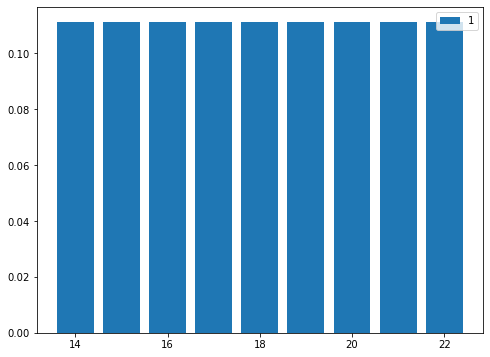

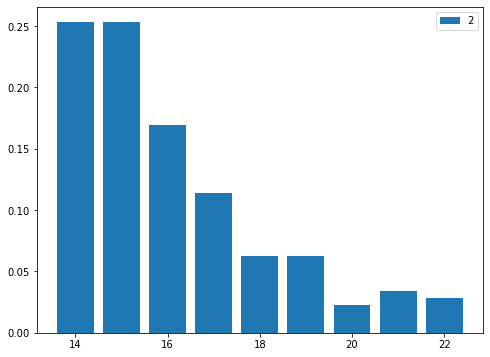

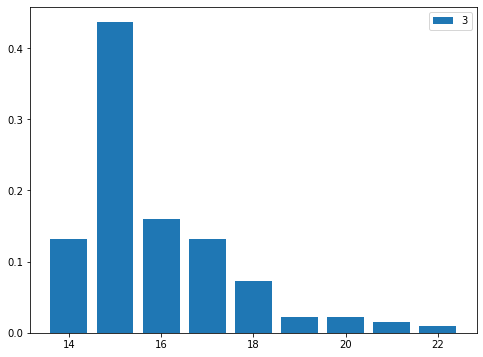

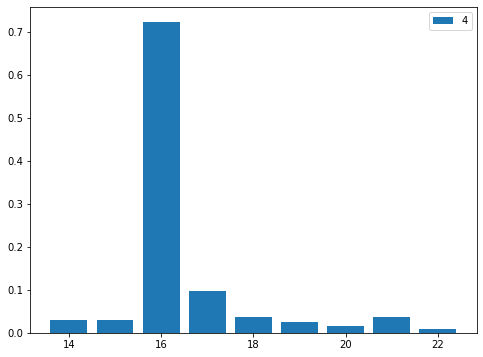

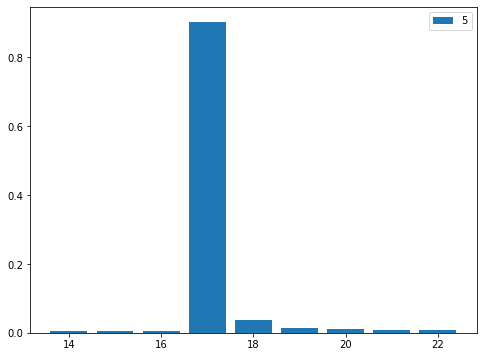

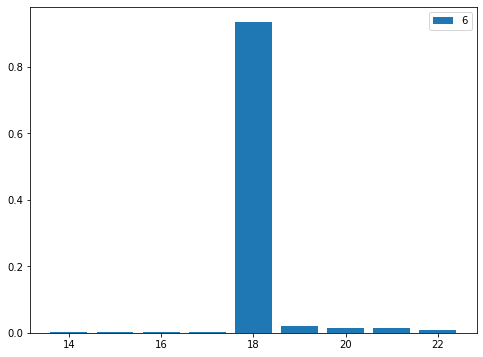

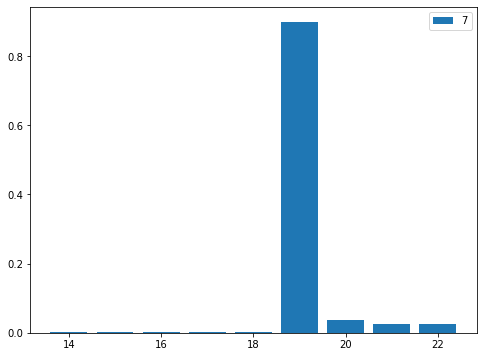

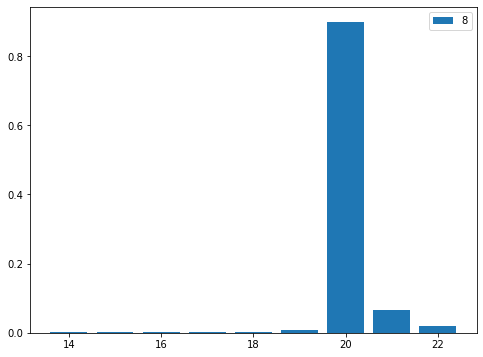

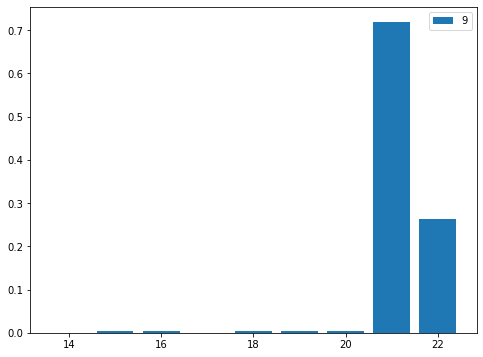

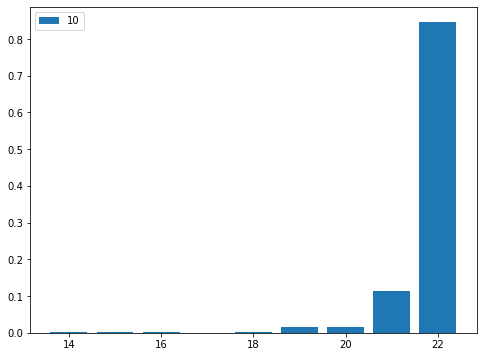

In [84]:
armsIWE=agent.armsIWE

for i in range(10):
    plt.figure(figsize=(8,6),
           facecolor='white')
    plt.bar(agent.ListSumHands, height=armsIWE[i,:]/np.sum(armsIWE[i,:]),label=f"{i+1}")
    plt.legend()
    plt.show()

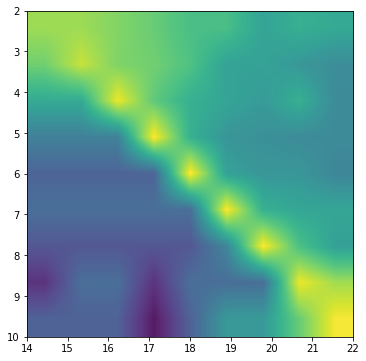

In [85]:
armsIWEcopy=deepcopy(armsIWE)
for i in range(10):
    armsIWEcopy[i,:]=armsIWEcopy[i,:]/np.sum(armsIWEcopy[i,:])

plt.figure(figsize=(8,6),
           facecolor='white')
extent = np.min(agent.ListSumHands), np.max(agent.ListSumHands),10, 2
plt.imshow(np.log(armsIWEcopy[1:,]),  cmap=plt.cm.viridis, alpha=.9, interpolation='bilinear',extent=extent)
plt.show()